In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pystackreg import StackReg

from scripts.batch_processing import motion_correction_based_on_ch2, extract_traces, merge_imaging_and_behavior, merge_sessions
from scripts.batch_analysis import generate_plots, spatial_corrmap, spatial_corrmap_pooled

# User settings

In [54]:
params = {
    "n_ch": 2,  # number of channels
    "n_z": 5,  # number of z slices
    "xy_smth": 4,  # smoothing in xy before registration (sigma 2D Gaussian)
    "perc": 10,  # settings for background subtraction: percentile
    "winsize": 50,  # and window size (winsize / f_ca = window in seconds)
    "f_ca": 6,  # sample rate imaging
    "f_ball": 50,  # sample rate ball velocity
    "f_beh": 200,  # sample rate behavior
    "beh_keys": [  # keys in behavior file to consider
        "pushing",
        "hindLegRub",
        "frontLegRub",
        "headGrooming",
        "abdomenGrooming",
        "PER",
        "midLeft+hindLegRub",
        "midRight+hindLegRub",
        # 'ObL1+R1'
    ],
    # transformation used for registration https://pystackreg.readthedocs.io/en/latest/readme.html#usage
    "reg": StackReg.SCALED_ROTATION,
    # path to folder
    "parent_dir": r"Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4",
    "overwrite": True,  # force overwriting files
}

# ensure `parent_dir` is Path object
params["parent_dir"] = Path(params["parent_dir"])

# selection rule for tif files
params["p_tifs"] = [
    *params["parent_dir"].glob("**/trials_to_register/*/trial*_00???.tif")
]

# set and create output folders
params["p_out"] = params["parent_dir"] / "kernel_comparison"
params["p_out_all"] = params["p_out"] / "all_data"
params["p_out_all"].mkdir(exist_ok=True, parents=True)

# print info
print("INFO: Saving files to {}".format(params["p_out"]))
print("INFO: Found {} files:".format(len(params["p_tifs"])))
for p in params["p_tifs"]:
    print(p)

INFO: Saving files to Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\kernel_comparison
INFO: Found 7 files:
Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\female12\trials_to_register\trial1_00002\trial1_00002.tif
Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\female12\trials_to_register\trial3_00001\trial3_00001.tif
Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\female3\trials_to_register\trial4_00001\trial4_00001.tif
Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\female3\trials_to_register\trial5_00001\trial5_00001.tif
Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\female6\trials_to_register\trial3_00001\trial3_00001.tif
Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\female6\trials_to_register\trial4_00001\trial4_00001.tif
Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_s

# Processing
The processing part contains
- motion correction
- fluorescence trace extraction
- merging behavior and imaging data

All output is stored in the `params["p_out"]` folder.
Here, the folder structure of all `params["p_tifs"]` files is regenerated relative to `params["parent_dir"]`.
These folders contain all intermediate files of the processing pipeline, 
as well as a `plots` folder with analysis for that specific TIF file.

The output folder further contains an `all_data` folder,
which contains analysis pooled over all TIF files.

## Motion correction
The motion correction is done with [pystackreg](https://pystackreg.readthedocs.io/en/latest/readme.html#summary), which is a python port of the TurboReg/StackReg extension in ImageJ.

The processing steps are
- maximum projection along z
- smoothing with 2D Gaussian along xy (`params['xy_smth']`)
- alignment based on channel 2 (`params['reg']`)

Following files are generated for each TIF file, split by channel:
- uncorrected maxproj data (`*ch1.tif` and `ch2.tif`)
- motion-corrected maxproj data (`*ch1reg.tif` and `ch2reg.tif`)
- mean maxproj image (`*ch1mean.bpm` and `*ch2mean.bpm`)
- side-by-side movies (quick quality control)
    - maxproj channel 1 and 2 (`*ch1ch2.mp4`)
    - uncorrected and motion-corrected maxproj channel 1 (`*ch1reg.mp4`)
    - uncorrected and motion-corrected maxproj channel 2 (`*ch2reg.mp4`)


For more details, look into the `scripts.batch_processing.motion_correction` function.



In [ ]:
motion_correction_based_on_ch2(params)

## Trace extraction
This part loads the motion-corrected TIF files saved to disk
and extracts the fluorescence traces for ROIs defined in the ImageJ Roi.zip file.

Check `ch1mean_rois.bmp` if ROIs are parsed correctly.

Following files are generated for each TIF file, split by channel.
The name indicates for which data the trace was extracted:
- `ch1raw/ch2raw`: raw data
- `r12`: ratio of ch1 to ch2
- `dch1/dch2`: baseline subtracted from raw data
- `dr12`: baseline subtracted from ratio
- `ch1/ch2`: background (last) ROI subtracted from raw data


In [ ]:
extract_traces(params)

## Merge imaging and behavior data
Imaging data, behavior data, and ball velocity data is recorded at different sampling rates.
Here, they are resampled to the sampling rate of the behavior data and merged into one pandas.DataFrame.

The ball velocity file is expected to be called `trial16.mat` for the TIF file `trial16_00001.tif`.

The behavior data file is expteced to be called `*-actions.mat`

In [80]:
import numpy as np
import pandas as pd
import pickle

from src.file_handling import (
    fname,
    get_matlab_files,
    load_ball,
    load_behavior,
)

from src.processing import (

    zscore_cols,
    resample_to_behavior,
    convolute_ca_kernel,
)

kernel = 'delta'

def merge_imaging_and_behavior(params):

    # load parameters
    p_tifs = params["p_tifs"]
    p_out = params["p_out"]
    p_parent = params["parent_dir"]
    overwrite = params["overwrite"]
    beh_keys = params["beh_keys"]
    f_ca, f_ball, f_beh = params["f_ca"], params["f_ball"], params["f_beh"]

    for p_tif in p_tifs:
        print()

        # load ROI traces from disk
        p_roi = fname(p_tif, "roi_traces.pickle", old_root=p_parent, new_root=p_out)
        if not p_roi.is_file():
            print(f"WARNING file with ROI traces not found, skipping {p_tif.parent}")
            continue
        else:
            with open(p_roi, "rb") as f:
                d_roi = pickle.load(f)

        # load behavior data and ball velocities
        p_mats = get_matlab_files(p_tif)
        if not p_mats:
            print(f"WARNING skipping {p_tif.parent}")
            continue
        else:
            p_ball, p_beh = p_mats
        ball = load_ball(p_ball)
        beh = load_behavior(p_beh, beh_keys)

        for method, traces in d_roi.items():
            if method != 'dr12':
                continue
            # check if already been processed
            p_df = fname(p_tif, f"data_{method}_{kernel}.parquet", old_root=p_parent, new_root=p_out)
            if p_df.is_file() and not overwrite:
                print(
                    f"INFO output files exists, skipping data merging for method {method} in {p_tif.parent}"
                )
                continue

            # match sample rates
            df = resample_to_behavior(traces, beh, ball, f_ca, f_ball, f_beh)
            # zscore ROIs
            df = zscore_cols(df, col_start="roi_")
            # convolute ball velocities and behavior with Ca kernel
            df = convolute_ca_kernel(df, f=f_beh)
            # zscore ball velocities
            df = zscore_cols(df, col_start="conv_ball_")

            # add additional data based on file and folder names
            pt = p_tif.parts
            cond, fly, trial = pt[-5], pt[-4], pt[-2]
            df.loc[:, "cond"] = cond  # e.g. fed/starved
            df.loc[:, "fly"] = fly  # fly number
            df.loc[:, "trial"] = trial  # trial number
            print(
                f"INFO parsing folder names: fly {fly} | trial {trial} | condition {cond}"
            )

            # save to disk
            print(f"INFO writing merged data to {p_df}")
            df.to_parquet(p_df)

            # optional (will be big files): save also as CSV
            # df.to_csv(p_df.with_suffix('.csv'))

merge_imaging_and_behavior(params)

def merge_sessions(params):
    "Merge data from all TIF files"

    # load parameters
    p_tifs = params["p_tifs"]
    p_out = params["p_out"]
    p_parent = params["parent_dir"]
    p_out_all = params["p_out_all"]
    overwrite = params["overwrite"]

    # get methods used for trace extraction
    all_pars = []
    for p in p_tifs:
        l = [*fname(p, "", old_root=p_parent, new_root=p_out).parent.glob(f"*data_dr12_{kernel}.parquet")]
        all_pars.extend(l)
    methods = {p.stem.split("_")[-2] for p in all_pars}

    # merge for each method separately
    for method in methods:
        # list of all *_data_{method}.parquet files
        p_pars = [fname(p, f"data_{method}_{kernel}.parquet", old_root=p_parent, new_root=p_out) for p in p_tifs]

        l = []
        for p_par in p_pars:
            if not p_par.is_file():
                print(f"WARNING skipping {p_par.parent}")
                continue
            else:
                print(f"INFO loading file {p_par}")
                df = pd.read_parquet(p_par)
                l.append(df)

        if l:
            # combine dataframes and save
            df = pd.concat(l, ignore_index=True)
            p_df = p_out_all / f"all_data_{method}_{kernel}.parquet"
            if overwrite:
                df.to_parquet(p_df)

            print(f"INFO contents of {p_df}")
            for f, d in df.groupby("fly"):
                print(f"     {f}", end=": ")
                for t, _ in d.groupby("trial"):
                    print(f"{t}", end=" ")
                print()
        else:
            # this check should not be necessary (?)
            print(f"WARNING no data files found, skipping {method}")

merge_sessions(params)


delta
INFO parsing folder names: fly female12 | trial trial1_00002 | condition FOMO-GCaMP6f-tdTomato_VNC_smth4
INFO writing merged data to Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\kernel_comparison\female12\trials_to_register\trial1_00002\trial1_00002_data_dr12_delta.parquet

delta
INFO parsing folder names: fly female12 | trial trial3_00001 | condition FOMO-GCaMP6f-tdTomato_VNC_smth4
INFO writing merged data to Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\kernel_comparison\female12\trials_to_register\trial3_00001\trial3_00001_data_dr12_delta.parquet

delta
INFO parsing folder names: fly female3 | trial trial4_00001 | condition FOMO-GCaMP6f-tdTomato_VNC_smth4
INFO writing merged data to Y:\Nino_2P_for_Salil\for_Nico\FOMO_imaging\FOMO-GCaMP6f-tdTomato_VNC_smth4\kernel_comparison\female3\trials_to_register\trial4_00001\trial4_00001_data_dr12_delta.parquet

delta
INFO parsing folder names: fly female3 | trial trial5_00001 | 

As a final processing step,
the data from all TIF files is merged into one pandas.DataFrame and 
saved to `params["all_data"] / all_data_{method}.parquet` (see _Trace extraction_).

# Analysis and plots

This part analyzes the fluorescence traces and behavior data and gerenerates plots.

The following plots are generated by `generate_plots` in the respective `params['p_out_all'] / {method}` folder
- `heatmap.svg`: Pearson correlation coefficients between all combinations of z-scored traces, Ca-kernel-convolved and z-scored ball velocities, and Ca-kernel-convolved behavior onsets
- `heatmap_{beh}.svg`: same as `heatmap.svg`, but with data filtered around behavior event
- `ccf.svg`: cross-correlation function between (i) z-scored traces and (ii) Ca-kernel-convolved and z-scored ball velocities and Ca-kernel-convolved behavior onsets
- `ccf_indv.svg`: same as `ccf.svg`, but not averaged over flies/trials
- `aligned_to_{beh}.svg`: average z-scored traces and smoothed (not Ca-kernel-convolved!) ball velocities



C:\Users\spillern\AppData\Local\Temp\ipykernel_8204\4097835426.py:21: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'kernel'] = pd.Categorical(df.loc[:, 'kernel'], categories=cats, ordered=True)


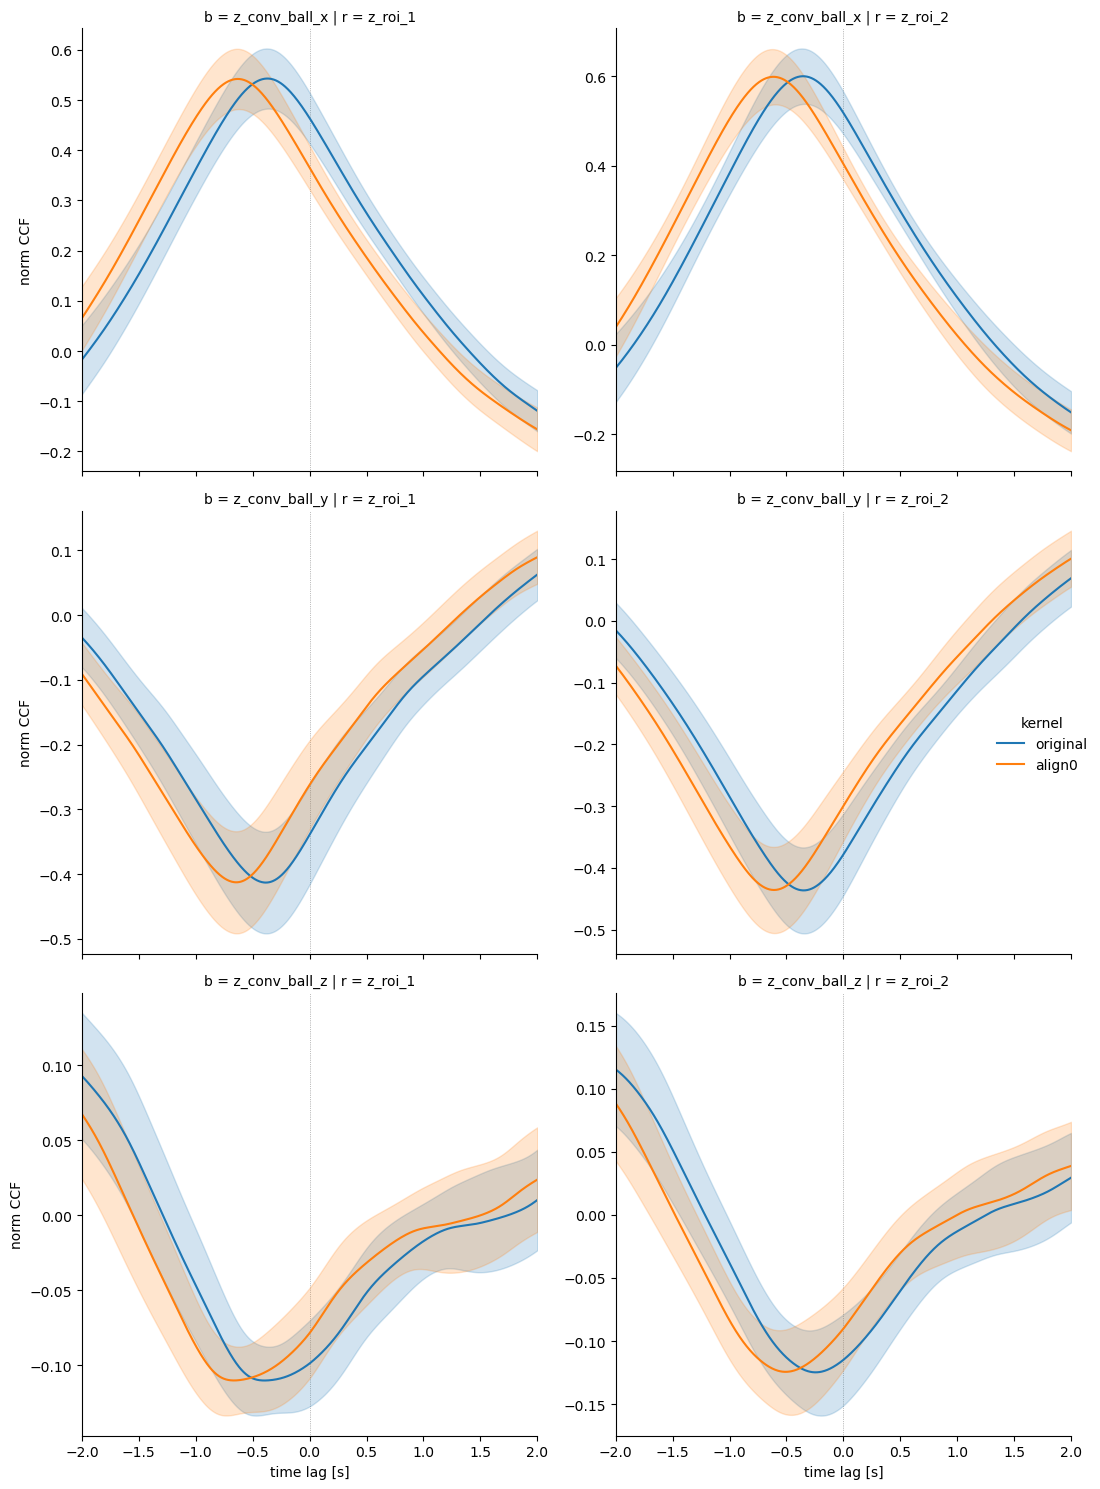

In [82]:
# analysis-specific parameters
params.update({
    "drop_rois": [3], # drop these ROIs for all plots in `generate_plots`
    "dt_beh": 5, # +- time window in s around behavior events in `heatmap_{beh}.svg`
    "dt_align": 5, # +- time window in s to plot in `aligned_to_{beh}.svg`
    "s_align": .25 # STD of Gaussian to smooth velocity in `aligned_to_{beh}.svg`
})
l = []
for p_kernel in params["p_out_all"].glob("all_data_dr12_*.parquet"):
    df = pd.read_parquet(p_kernel)
    kernel = p_kernel.stem.split("_")[-1]
    df.loc[:, 'kernel'] = kernel
    l.append(df)
df = pd.concat(l, ignore_index=True)
df = df.fillna(0)  # TODO workaround because of missing behavior

df = df.drop(columns=[f"z_roi_{i}" for i in params['drop_rois']])

cats = ['original', 'gauss75', 'delta']
cats = ['original', 'align0']
df.loc[:, 'kernel'] = pd.Categorical(df.loc[:, 'kernel'], categories=cats, ordered=True)


import pandas as pd
from src.visualization import plot_ccf

import matplotlib.pylab as plt
import seaborn as sns

from src.processing import calculate_ccf


def get_ccf(df_tot, f, col1, col2, col2_):
    l = []
    for k, df in df_tot.groupby('kernel'):
        d = calculate_ccf(df, dt=2, f=f, col1=col1, col2=col2, col2_=col2_)
        d = d.dropna(axis=0)
        d.loc[:, 'kernel'] = k
        l.append(d)
    return pd.concat(l, ignore_index=True)

def plot_ccf(df, f, col1='z_roi_', col2='z_conv_ball_', col2_='z_conv_ball_', path=''):
    "Calculate and lot cross-correlation functions between (i) `col1` and (ii) `col2` + `col2_`"

    kw_args = {
        'x': 't',
        'y': 'ccf',
        'col': 'r', 
        'hue': 'kernel',
        'row': 'b',
    }

    d = get_ccf(df, f=f, col1=col1, col2=col2, col2_=col2_)

    g = sns.relplot(data=d, kind='line', facet_kws={'sharey': False}, errorbar='se', **kw_args)
    g.set_axis_labels('time lag [s]', 'norm CCF')

    for ax in g.axes.flatten():
        ax.axvline(0, ls=':', lw=.5, c='gray', zorder=-1)
        ax.margins(x=0)
    
    fig = g.figure
    fig.tight_layout()
    # if path:
    #     fig.savefig(path)
    #     plt.close(fig)
plot_ccf(df, f=params['f_beh'])

## spatial correlation maps
Spatial correlation maps show the pixel-wise correlation between
(i) motion-corrected raw data and
(ii) Ca-kernel-convolved ball velocities and Ca-kernel-convolved behavior onsets.
Because these are calculated per TIF file, they are saved in the `params['p_out'] / path_to_tif / 'corrmaps'` folder

The following plots are generated by `spatial_corrmap` 
(see `plot` folder for individual TIF files)
- `{col}_1xy.svg`: spatial correlation maps for `col` separated by channel 1 and 2
- `corrmap_{col}_{ch}.npy`: not a plot, but correlation data file to be reused for plotting

Because the spatial correlation maps take a long time to calculate,
we can specifically choose the TIF files for which to calculate the maps.

In [ ]:
# plot spatial correlation maps for subset of TIF files
p_tifs = params["p_tifs"][:1]
spatial_corrmap(params, p_tifs)

Here we calculate the spatial correlation map pooled over multiple TIF files (e.g. all trials of one fly).

This requires motion-correcting all trials together.
Since the plots contain data from multiple TIF files, they
are saved in `params['p_out'] / pool_name / 'correlation_maps'`

In [ ]:
# choose TIF files to pool
p_tifs = [ *params['parent_dir'].glob('female4/trials_to_register/*/*0000?.tif') ]
# define unique name for folder
pool_name = 'female4_all_trials'
# run 
spatial_corrmap_pooled(params, p_tifs, pool_name)